In [1]:
import numpy as np
import pandas as pd
import scipy
import datetime as dt
import matplotlib
import matplotlib.colors as cols
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime
import scipy.stats as stats
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

<a id='introduction'></a>
# Forecasting Optimal Inventory Levels

All businesses rely on sales.  Businesses that use products will have inventory requirements to make sure sales are handled timely and appropriately.  A company will likely need to keep a cap on inventory in an effort not to overspend on inventory during a slow-sales period. Oftentimes a company knows when their busy and slow seasons are (Christmas, Black Friday, different seasons, etc.) and thus they can prepare inventory accordingly. It is the other times of the year where a company could benefit from Time Series analysis for surprise sales increases/decreases. Using Time Series analysis, I am analyzing inventory & sales data to forecast optimal inventory levels according to sales needs throughout the year. My solution would help optimize the appropriate amount of inventory to stock according to sales during different parts of the year.

From a logical standpoint, inventory and sales should have some sort of correlation - the more something sells, the more need for inventory of that specific item.  This project aims to see how closely related inventory and sales are and what events may fluctuate that relationship.

## Table of Contents

[1. Introduction](#introduction)<br>
[2. Data](#data)<br>
[3. Exploratory Analysis](#exploratroryanalysis)<br>
* [Linear Regression](#linear)

[4. Seasonal Decomposition](#seasonaldecomposition)<br>
[5. Model Preparation](#modelpreparation)<br>
* [Stationarity Tests](#stationaritytests)<br>
* [Arima](#arima)<br>
* [Inventory Models](#inventory)<br>
* [Sales Models](#sales)

[6. Further Exploration:](#further)<br>
* [SARIMAX](#sarimax)<br>
* [Other Verification](#other)

[7. Summary](#summary)<br>

<a id='data'></a>
# Data

The U.S. Bureau of the Census monthly inventory & sales data from between January 1st, 1992 - October 1st, 2018. Retrieved from FRED, Federal Reserve Bank of St. Louis: 

  * **Total Business Inventories** ([BUSINV](https://fred.stlouisfed.org/series/BUSINV))
* Units:  Millions of Dollars, End of Period, Seasonally Adjusted
* Frequency:  Monthly, End of Period
  * **Total Business Sales** ([TOTBUSSMSA](https://fred.stlouisfed.org/series/TOTBUSSMSA))
* Units:  Millions of Dollars, Seasonally Adjusted
* Frequency:  Monthly

From [U.S. Bureau of the Census](https://www.census.gov/econ/currentdata/dbsearch?program=MTIS&startYear=1992&endYear=2019&categories=TOTBUS&dataType=SM&geoLevel=US&adjusted=1&notAdjusted=1&errorData=0):<br>
"The Manufacturing and Trade Inventory and Sales estimates are based on data from three surveys: The Monthly Retail Trade Survey (MRTS), the Monthly Wholesale Trade Survey (MWTS), and the Manufacturers' Shipments, Inventories, and Orders Survey (M3)." 

**Definitions via [US Census](https://www.census.gov/mtis/definitions.html):**

**Inventories (Retail)** - Merchandise inventories are the value of stocks of goods held for sale. The inventories estimates represent the value, at cost, of the merchandise available for sale as of the last day of the report period. Methods of valuation may vary according to the accounting practices of each firm. The estimates provided in this report are valued on a non-LIFO (last in, first out) basis. Note — LIFO is a method of valuing inventory where the latest items of merchandise added to the inventory are the first ones taken out. Non-LIFO would mean that another method, such as FIFO (first in, first out), was used to establish the value of the inventory available for sale. Merchandise inventories are shown for stores and warehouses servicing retail establishments. Included are only those warehouses that maintained supplies of merchandise primarily intended for distribution within the organization.

**Inventories (Manufacturing)** - Total inventories represent the value of the end-of-month stocks regardless of stage of fabrication (whether in the form of purchased materials and supplies, work in process, or finished goods). These inventories are valued at cost using any valuation method other than LIFO. Inventories associated with the non-manufacturing activities of your company are excluded.

**Sales (Retail)** - Sales include merchandise sold (for cash or credit at retail or wholesale) by establishments primarily engaged in retail trade. Services that are incidental to the sale of merchandise, and excise taxes that are paid by the manufacturer or wholesaler and passed along to the retailer are also included. Sales are net, after deductions, of refunds and allowances for merchandise returned by customers. Sales exclude sales taxes collected directly from customers and paid directly to a local, state, or federal tax agency.

The [estimates of sales](https://www.census.gov/mtis/definitions.html) measure the operations receipts rendered by stores that primarily sell at retail. The sales estimates represent total sales and receipts of all establishments primarily engaged in retail trade. They do not include sales at retail by manufacturers, wholesalers, service establishments, and others whose primary activity is other than retail trade. Because the retail establishment is the basic unit of measure, the published estimates of sales by type of retail store are not intended to measure the total sales for a given commodity or merchandise line.


This data will serve well in this project to build a foundation.  The goal is to be able to use the foundation in multiple applications.

In [2]:
# Load the data
bus_inv = pd.read_csv('BUSINV.csv')

In [3]:
bus_sales = pd.read_csv('TOTBUSSMSA.csv')

In [4]:
df = pd.merge(bus_inv, bus_sales)

In [5]:
df.head(13)

,DATE,BUSINV,TOTBUSSMSA
0,1992-01-01,808292,517626
1,1992-02-01,809600,520289
2,1992-03-01,812725,530715
3,1992-04-01,815453,533290
4,1992-05-01,815016,536742
5,1992-06-01,820447,541482
6,1992-07-01,825098,545177
7,1992-08-01,826136,541368
8,1992-09-01,827513,546733
9,1992-10-01,827914,545987


In [6]:
df.tail(13)

,DATE,BUSINV,TOTBUSSMSA
309,2017-10-01,1884375,1385361
310,2017-11-01,1893380,1402751
311,2017-12-01,1903551,1410433
312,2018-01-01,1915012,1406327
313,2018-02-01,1925817,1411971
314,2018-03-01,1923669,1420071
315,2018-04-01,1929393,1429298
316,2018-05-01,1935563,1447550
317,2018-06-01,1937569,1451814
318,2018-07-01,1950641,1455246


By viewing the first and last 13 entries of the data, we can see that there is one row per month.  The first entry is from January 1, 1992.  The last entry is October 1, 2018. The data should be slightly less than 27 years total.

In [7]:
df.describe()

,BUSINV,TOTBUSSMSA
count,3.220000e+02,3.220000e+02
mean,1.324969e+06,9.783024e+05
std,3.257876e+05,2.672501e+05
min,8.082920e+05,5.176260e+05
25%,1.071417e+06,7.451105e+05
50%,1.275006e+06,9.780760e+05
75%,1.581125e+06,1.247444e+06
max,1.982161e+06,1.469915e+06


In [8]:
# checking for null values
df.isnull().sum()

DATE          0
BUSINV        0
TOTBUSSMSA    0
dtype: int64

There are no missing values. It also appears that inventory values are generally one order of magnitude above that of sales (e+6 *vs.* e+5).

In [9]:
# checking amount of data (rows, columns)
df.shape

(322, 3)

In [10]:
(df.shape[0])/12

26.833333333333332

Confirmed - there is nearly 27 years of data

In [11]:
df['BUSINV'].dtype

dtype('int64')

In [12]:
df['TOTBUSSMSA'].dtype

dtype('int64')

In [13]:
# convert to float to avoid ARIMA error
df['BUSINV'] = df['BUSINV'].astype(float)

In [14]:
df['BUSINV'].dtype

dtype('float64')

In [15]:
df['TOTBUSSMSA'] = df['TOTBUSSMSA'].astype(float)

In [16]:
df['TOTBUSSMSA'].dtype

dtype('float64')

<a id='exploratroryanalysis'></a>
# Exploratory Analysis
[return to introduction](#introduction)

Let's see what the data looks like on a plot.  From there we can gather an overall sense of what is happening.  After the inital graph, we can check for any correlations between inventory and sales data.   

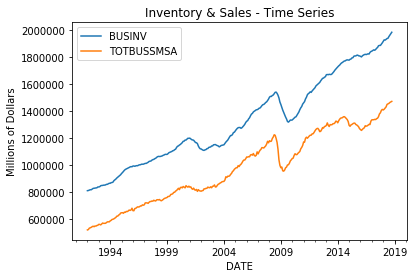

In [17]:
# Use Pandas to create date based index
df.index = pd.to_datetime(df.DATE)
df.plot()
plt.title('Inventory & Sales - Time Series')
plt.ylabel('Millions of Dollars')
plt.show()

Inventories and Sales show very similar patterns with an overall increase since 1992; however, there are declines from 2001-2002 and 2008-2010.  Sales has a slight dip from 2014-2016, which is not observed for Inventory.

### Correlation Between Inventory & Sales Data

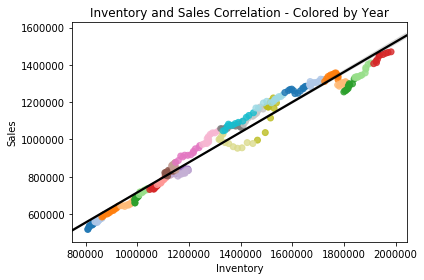


Inventory/Sales Regression: LinregressResult(slope=0.8072443725004758, intercept=-91271.04900900263, rvalue=0.984060262798231, pvalue=4.589048026218709e-242, stderr=0.008155044777049257)


In [18]:
# coloring by years
df['year']= pd.DatetimeIndex(df['DATE']).year
df['color']= 'black'
colors = dict(zip(df['year'].unique(),
                  map(cols.rgb2hex,sns.color_palette("tab20", len(df['year'].unique())))))
for key, value in colors.items():
    df['color'][df['year'] == key] = value

sns.regplot(df['BUSINV'], df['TOTBUSSMSA'], line_kws={'color':'black'}, scatter_kws={'color':None, 'facecolors':df['color']})
plt.title('Inventory and Sales Correlation - Colored by Year')
plt.xlabel('Inventory')
plt.ylabel('Sales')

plt.tight_layout()
plt.show()

print('\nInventory/Sales Regression:', 
      stats.linregress(df['BUSINV'][len(df['BUSINV'])-len(df['TOTBUSSMSA'].dropna()):], df['TOTBUSSMSA'].dropna()))

From the results above we can see that there is a strong correlation between Sales and Inventory values (r value = 0.984). Let's then see if Inventory can be predicted from Sales with a linear regression.

<a id='linear'></a>
# Linear Regression
[return to introduction](#introduction)

In [19]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df['BUSINV'].values.reshape(-1, 1)
X = df[['TOTBUSSMSA', 'year']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[7.44430940e-01 1.59862716e+04]]

Intercept: 
 [-31454493.78405693]

R-squared:
0.9738444779301392


In [20]:
# Train Test Split
data = X
target = Y

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit(data, target).score(data, target)))

With 20% Holdout: 0.979441864577066
Testing on Sample: 0.9738444779301392


In [21]:
cross_val_score(regr, data, target, cv=10)

array([-0.76545418, -1.41419817,  0.35532488, -0.57728928, -1.18844781,
        0.32793892, -0.58485071,  0.10281424, -1.75498617, -3.97616896])

When trying to predict Inventories by Sales and Years, we had really good train/test results; however, the cross validation showed there was a lot of overfitting.  Let's try predicting Sales base on Inventories and Years.


In [22]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df['TOTBUSSMSA'].values.reshape(-1, 1)
X = df[['BUSINV', 'year']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[4.70045008e-01 1.44555175e+04]]

Intercept: 
 [-28626637.82385442]

R-squared:
0.9754578977895324


In [23]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit(data, target).score(data, target)))



With 20% Holdout: 0.979441864577066
Testing on Sample: 0.9738444779301392


In [24]:
cross_val_score(regr, data, target, cv=10)

array([-0.76545418, -1.41419817,  0.35532488, -0.57728928, -1.18844781,
        0.32793892, -0.58485071,  0.10281424, -1.75498617, -3.97616896])

When trying to predict Sales by Inventories and Years, we again had really good train/test results but poor cross validation results.  Linear Regression does not take into effect time like an ARIMA model does. What we observed in the cross validation is overfitting. Overfitting is when your model catches extra, random noise in its analysis instead of finding the true underlying relationships.

We can see below in our residual plots where the random noise is that is causing our cross validation to overfit.

<a id='seasonaldecomposition'></a>
# Seasonal Decomposition
[return to introduction](#introduction)

Now we are going to look at two imporant aspects of the time-based data - **trends and seasonality**

Inventories Yearly


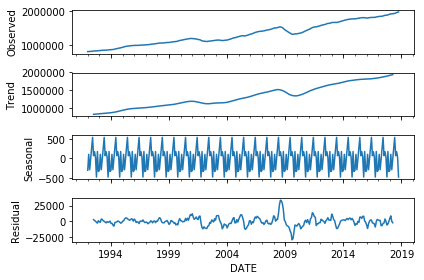

Sales Yearly


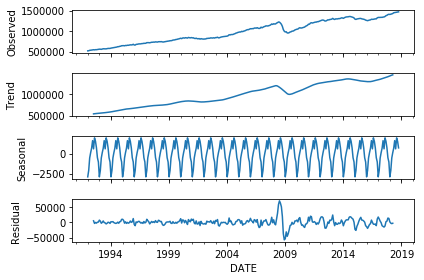

In [25]:
# Inventories Yearly 
print('Inventories Yearly')
run_decompose_inv = seasonal_decompose(df['BUSINV'].dropna(), model='additive')
run_decompose_inv.plot()
plt.show()

# Sales Yearly 
print('Sales Yearly')
run_decompose_sales = seasonal_decompose(df['TOTBUSSMSA'].dropna(), model='additive')
run_decompose_sales.plot()
plt.show()

**Trend** -  can be summarized as the overall direction data is moving over time.  This is a very important aspect to analyze in regards to direction and speed. The time-data decomposition shows both data sets are generally increasing. Similar shape to Observed.  Trend sized doubled for Inventories and triples for Sales over the time period observed.  The Trend charts are the most prominent observation.

**Seasonal** - should show repeating cycles over a period of time (think certain items sell better at different times of the year). The time-data decomposition shows a repeating short term cycle in a series - this is what we expect since data is continuous.  Inventories look to have their spike slightly before the seasonal sales spike (middle of year).  This makes sense as businesses typically know when to increase their inventory in anticipation of a busy sales season.

**Residual** the difference between the prediction and observed quantity.  A good residual representation will have show no correlation and have a mean of 0. The time-data decomposition shows a very similar patterns between Inventories and Sales - has no correlation and a mean of 0 as expected.

<a id='modelpreparation'></a>
# Model Preparation
[return to introduction](#introduction)

In [26]:
# 20% of 322 data points
0.2*322

64.4

In [27]:
# 65 month history will be used for the model
inv_train65 = df['BUSINV'][:-65].dropna()
inv_test65 = df['BUSINV'][-65:]
print('Inventory train:', len(inv_train65), 
      '\nInventory test:', len(inv_test65), 
      '\nFraction of total data set:', len(inv_test65)/len(df['BUSINV'].dropna()))

sales_train65 = df['TOTBUSSMSA'][:-65]
sales_test65 = df['TOTBUSSMSA'][-65:]
print('\nSales train:', len(sales_train65), 
      '\nSales test:', len(sales_test65),
     '\nFraction of total data set:', len(sales_test65)/len(df['TOTBUSSMSA'].dropna()))

Inventory train: 257 
Inventory test: 65 
Fraction of total data set: 0.20186335403726707

Sales train: 257 
Sales test: 65 
Fraction of total data set: 0.20186335403726707


<a id='stationaritytests'></a>
# Stationarity Tests
[return to introduction](#introduction)

Stationarity is present when a data set has statistical properties (mean, variance, etc.) constant over time.

One way to test for stationarity is the [Augmented Dickey-Fuller](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) (ADF) test.  If p < 0.05, we reject the null hypothesis and assume the alternate hypothesis of stationarity.  If p > 0.05, we accept the null hypothesis of non-stationarity.

If the data set is non-stationary, using differencing will be required to make it stationary.

In [28]:
# Write function to test for stationarity
def stationarity_test(name, x, i = 0):
    result = adfuller(x)
       
    if result[1] > 0.05:
        print('{} data set is NOT stationary at I = {}!'.format(name, i))
        diff = x-x.shift(periods=1)
        stationarity_test(name, diff[1:], i+1)
    else:
        print('{} is stationary at I = {}'.format(name,i))
        print('ADF Statistic %f' % result[0])
        print('p-value: %f\n' % result[1])

In [29]:
stationarity_test('Inventories - 65', inv_train65)
stationarity_test('Sales - 65', sales_train65)

Inventories - 65 data set is NOT stationary at I = 0!
Inventories - 65 is stationary at I = 1
ADF Statistic -4.978559
p-value: 0.000024

Sales - 65 data set is NOT stationary at I = 0!
Sales - 65 is stationary at I = 1
ADF Statistic -5.681912
p-value: 0.000001



### Differencing

The ARIMA model that will be used below needs to have stationary data in order to work properly. Differencing, which is subtracting each term from its following term, is an easy way to make our data stationary. 

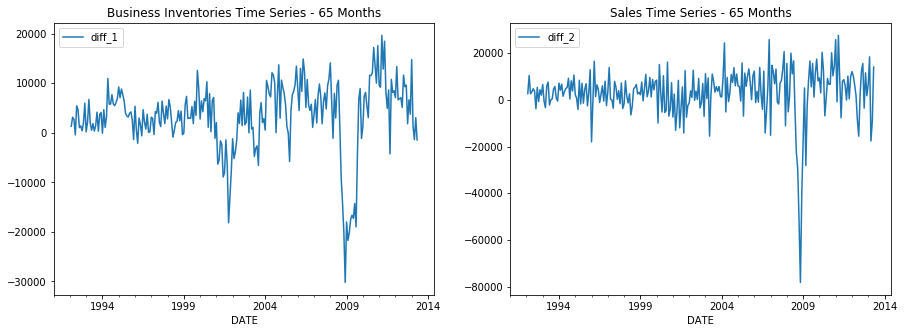

In [30]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1,2,1)

df['diff_1'] = inv_train65 - inv_train65.shift(periods=1)
df.plot(y='diff_1', ax =ax1)
plt.title('Business Inventories Time Series - 65 Months')

ax2 = fig.add_subplot(1,2,2)
df['diff_2'] = sales_train65 - sales_train65.shift(periods=1)
df.plot(y='diff_2', ax = ax2)
plt.title('Sales Time Series - 65 Months')

plt.show()

<a id='arima'></a>
# ARIMA
[return to introduction](#introduction)

An ARIMA model is a class of statistical models for analyzing and forecasting time series data.

It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts.

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

**AR: Autoregression.** A model that uses the dependent relationship between an observation and some number of previous (lagged) observations.<br>
**I: Integrated.** The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.<br>
**MA: Moving Average.** A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

**p:** The number of lag observations included in the model, also called the lag order.<br>
**d:** The number of times that the raw observations are differenced, also called the degree of differencing.<br>
**q:** The size of the moving average window, also called the order of moving average.<br>

A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.

### PACF - Partial Autocorrelation Function

The PACF represents the correlation of our time series with a lagged version of itself. The high correlations will help us with our ARIMA modeling.  This is a method to estimate the lag order and provides a visual way to analyze the differencing.

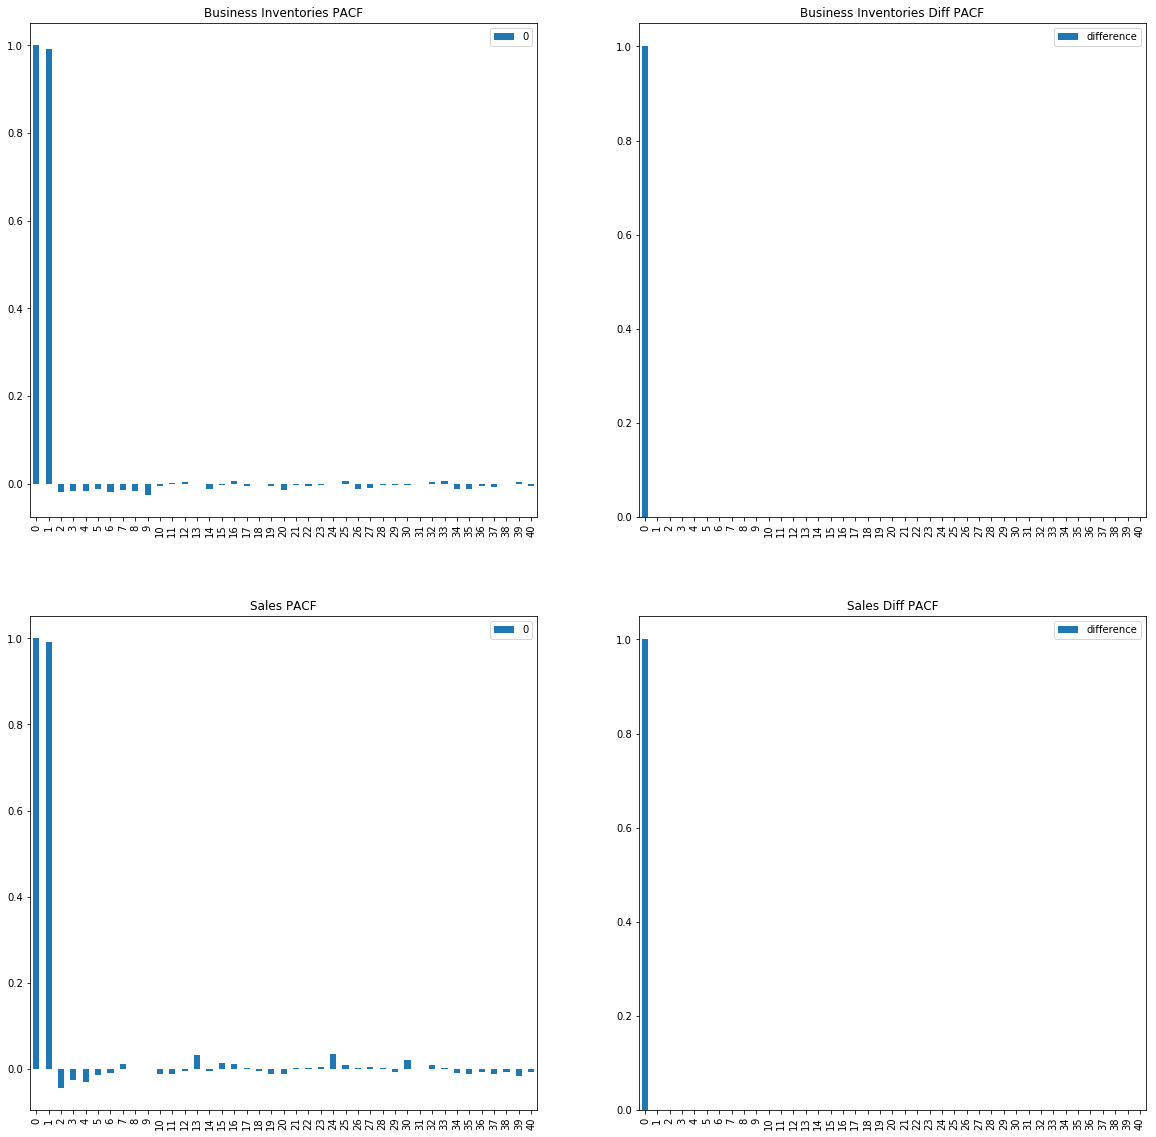

In [31]:
# Plotting the PACF
from statsmodels.tsa.stattools import pacf

fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(2,2,1)
x_acf_i = pd.DataFrame(pacf(df['BUSINV']))
x_acf_i.plot(kind='bar', ax = ax1)
plt.title("Business Inventories PACF")

ax2 = fig.add_subplot(2,2,3)
x_acf_s = pd.DataFrame(pacf(df['TOTBUSSMSA']))
x_acf_s.plot(kind='bar', ax = ax2)
plt.title("Sales PACF")

ax3 = fig.add_subplot(2,2,2)
x_acf_diff_i = pd.DataFrame(pacf(df.diff_1[1:]))
x_acf_diff_i.plot(kind='bar', ax = ax3)
plt.title("Business Inventories Diff PACF")
plt.legend(['difference'])

ax4 = fig.add_subplot(2,2,4)
x_acf_diff_s = pd.DataFrame(pacf(df.diff_2[1:]))
x_acf_diff_s.plot(kind='bar', ax = ax4)
plt.title("Sales Diff PACF")
plt.legend(['difference'])

plt.show()

We learned from the Augmented Dickey-Fuller (ADF) test that differencing at I(d)=1 would be required.  Using the differenced PACF confirms this and does not show any high correlations.  The differenced plots do not show any correlation at all, which suggests that there is no association with lagged terms and the lag order to use is 0.

## ARIMA Optimization
The functions below (via [GitHub](https://github.com/missytracy/Thinkful-Unit-7/blob/master/Solar%20Stock%20Prediction.ipynb)) are defined to fit and test various ARIMA configurations and determine the best model for the data using a grid exploration. The Akaike Information Criteria (AIC) is a measure of the degree of information contained in the model.  We would normally choose the lowest AIC value provided by statsmodels that minimizes information loss. 

This search uses a range of model configurations to make predictions and test those predictions against known values.  This will provide us with a AR(p), I(d), MA(q) configuration that minimizes mean squared error.  "In statistics, the mean squared error or mean squared deviation of an estimator measures the average of the squares of the errors—that is, the average squared difference between the estimated values and what is estimated. MSE is a risk function, corresponding to the expected value of the squared error loss." [Wikipedia](https://en.wikipedia.org/wiki/Mean_squared_error)

After the best configuration is determined, we will verify that our data is random and normally distributed.

In [32]:
# Function to generate predictions for a given arima order
def evaluate_arima(train, test, arima_order):
    # Populate history based on training set
    history = [x for x in train]
    
    # Create blank list of predictions to populate
    predictions = list()
    
    # Use rolling forward walk predictions.  Fit model using history,
    # adding each prediction to history to continue forecasting
    
    for i in range(len(test)):
        # Fit using history
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        
        # Get prediction
        y_pred = model_fit.forecast()[0]
        
        # Append prediction to prediction list to check accuracy 
        predictions.append(y_pred)
        
        # Append to history to continue to rolling forecast 
        history.append(y_pred)
    
    error = mean_squared_error(test, predictions)
    return error

# Function to determine best arima order combination based on lowest MSE
def arima_gridsearch(train, test, p_vals, d_vals, q_vals):
    
    best_score = float('inf') 
    best_config = None
    for p in p_vals:
        for d in d_vals:
            for q in q_vals:
                arima_order = (p, d, q)
                try:
                    mse = evaluate_arima(train, test, arima_order)
                    if mse < best_score:
                        best_score, best_config = mse, arima_order
                    print('ARIMA config: {}; MSE:{}'.format(arima_order, mse))
                except (ValueError, np.linalg.LinAlgError): # ignore non converging errors
                    pass
    
    print('Best ARIMA config:', best_config)
    print('MSE:', best_score)

# Function to evaluate residuals
def plot_residuals(name, train, p, d, q):
    model = ARIMA(train, order=(p,d,q))
    model_fit = model.fit()
    residuals = model_fit.resid
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('{}: {},{},{} Residuals'.format(name, p, d, q))
    residuals.plot()
    
    plt.subplot(1,2,2)
    residuals.hist(bins=25)
    plt.title('{} Residual Histogram'.format(name))
    plt.show()

# Function to plot predictions
def plot_predictions(name, train, test, p, d, q):
    
    arima_order = (p,d,q)
    
    history = [x for x in train]
    
    # Create blank list of predictions to populate
    predictions = list()
    
    # Recreate evaluate_arima model.  Need to do this instead of calling existing model
    # to return predictions list
    
    for i in range(len(test)):
        # Fit using history
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        
        # Get prediction
        y_pred = model_fit.forecast()[0]
        
        # Append prediction to prediction list to check accuracy 
        predictions.append(y_pred)
        
        # Append to history to continue to rolling forecast 
        history.append(y_pred)
     
    # Plots
    plt.figure(figsize=(10, 5))
    
    plt.subplot(121)
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, predictions, label='Predictions')
    plt.title('{} Prediction Validation: - Full Time Series'.format(name))
    plt.ylabel('Price ($)')
    plt.xticks(rotation=60)
    plt.legend()
    
    plt.subplot(122)
    plt.autoscale()
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, predictions, label='Predictions')
    plt.title('{} Prediction Validation - 2018'.format(name))
    plt.ylabel('Price ($)')
    plt.ylim(min(predictions) - 5, max(predictions) + 5)
    plt.xlim([datetime.date(2018, 1, 1), datetime.date(2018, 6, 1)])
    plt.xticks(rotation=60)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

<a id='inventory'></a>
# Inventory Models
[return to introduction](#introduction)

### Determine the best model configuration for Inventory data

In [33]:
# Fit and test Inventory ARIMA model- 65 month test period
arima_gridsearch(inv_train65, inv_test65, range(3), range(2), range(0, 11, 2))

ARIMA config: (0, 0, 0); MSE:387533656827.84186
ARIMA config: (0, 1, 0); MSE:1827953369.085637
ARIMA config: (0, 1, 2); MSE:2132769317.798396
ARIMA config: (0, 1, 4); MSE:2715888727.581187
ARIMA config: (0, 1, 6); MSE:2788035117.981617
ARIMA config: (0, 1, 8); MSE:2983040332.735716
ARIMA config: (1, 0, 0); MSE:28602631010.36556
ARIMA config: (1, 0, 6); MSE:33631486344.060806
ARIMA config: (1, 0, 8); MSE:32906611201.73778
ARIMA config: (1, 0, 10); MSE:39857725510.06174
ARIMA config: (1, 1, 0); MSE:3271206355.3049693
ARIMA config: (1, 1, 2); MSE:4535196786.906351
ARIMA config: (1, 1, 4); MSE:4616282386.748677
ARIMA config: (1, 1, 6); MSE:4760234975.083741
ARIMA config: (1, 1, 8); MSE:5188892519.205965
ARIMA config: (1, 1, 10); MSE:5419658638.305693
ARIMA config: (2, 0, 0); MSE:38603392288.6445
ARIMA config: (2, 0, 2); MSE:53932815943.870026
ARIMA config: (2, 0, 4); MSE:53375263347.71449
ARIMA config: (2, 0, 6); MSE:53029719555.17502
ARIMA config: (2, 0, 8); MSE:47998723812.01823
ARIMA co

### Plotting the residuals.  They should be random and have a normal distribution.

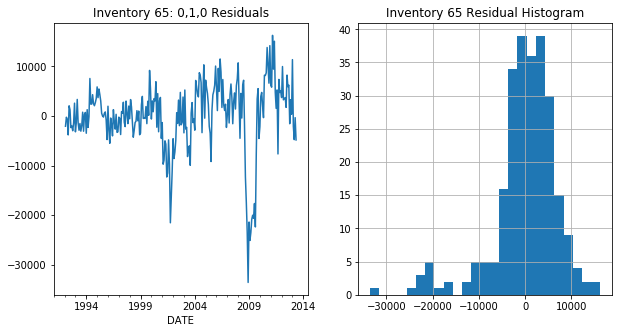

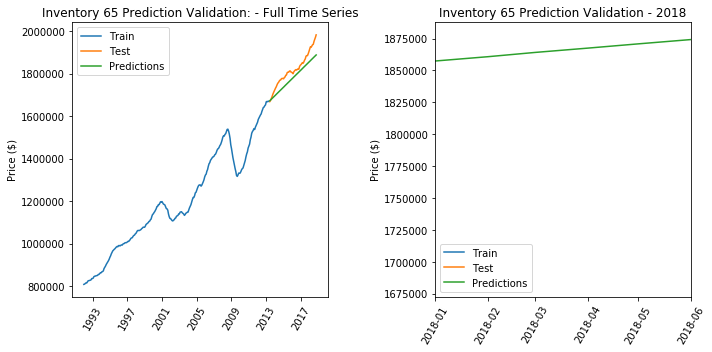

In [34]:
plot_residuals('Inventory 65', inv_train65, 0, 1, 0)
plot_predictions('Inventory 65', inv_train65, inv_test65, 0, 1, 0)

Our residuals were random and normally distributed.  Now let's check with the statsmodels package on **all** of Inventory data:

                             ARIMA Model Results                              
Dep. Variable:               D.BUSINV   No. Observations:                  321
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -3281.793
Method:                           css   S.D. of innovations           6665.604
Date:                Sat, 09 Feb 2019   AIC                           6567.586
Time:                        12:31:39   BIC                           6575.129
Sample:                    02-01-1992   HQIC                          6570.598
                         - 10-01-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3656.9128    372.038      9.829      0.000    2927.732    4386.093
Inventory Residuals Description
count    3.210000e+02
mean     1.269326e-12
std      6.676010e+03
min     -3.385491e+04
25%     -2.

Text(0.5,1,'0,1,0 Histogram of Residuals')

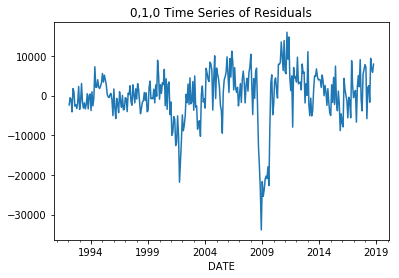

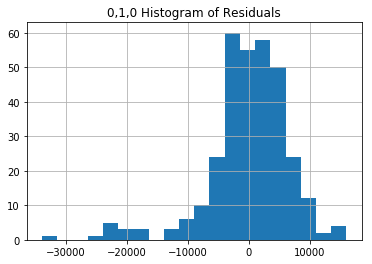

In [35]:
# Verify that our algorithm above is working properly
model_inv_010 = ARIMA(df['BUSINV'], order=(0,1,0))
model_inv_010_fit = model_inv_010.fit()
print(model_inv_010_fit.summary())
print('Inventory Residuals Description')
print(model_inv_010_fit.resid.describe())

residuals_010 = pd.DataFrame(model_inv_010_fit.resid)

residuals_010.plot(legend=False)
plt.title('0,1,0 Time Series of Residuals')

residuals_010.hist(bins=20)
plt.title('0,1,0 Histogram of Residuals')

Our constant of 3656.9128 is our expected increase in value for each day.

Our p-value is less than 0.05, so that gives more than the 95% confidence interval that the coefficient has a significant effect on our outcome.

Let's see what we get with the second lowest MSE score for Inventory 65:

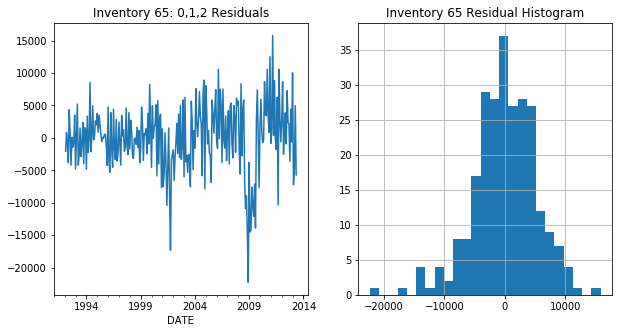

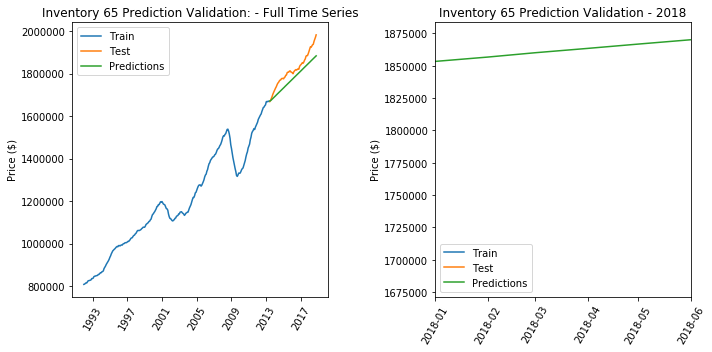

In [36]:
# next best model
plot_residuals('Inventory 65', inv_train65, 0, 1, 2)
plot_predictions('Inventory 65', inv_train65, inv_test65, 0, 1, 2)

The data is random and normally distributed with a good prediction indicator.

                             ARIMA Model Results                              
Dep. Variable:               D.BUSINV   No. Observations:                  321
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -3199.127
Method:                       css-mle   S.D. of innovations           5149.223
Date:                Sat, 09 Feb 2019   AIC                           6406.255
Time:                        12:31:46   BIC                           6421.340
Sample:                    02-01-1992   HQIC                          6412.278
                         - 10-01-2018                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           3656.9128    522.522      6.999      0.000    2632.789    4681.037
ma.L1.D.BUSINV     0.4904      0.067      7.299      0.000       0.359       0.622
ma.L2.D.BUSINV     0.3313      0.063

Text(0.5,1,'0,1,2 Histogram of Residuals')

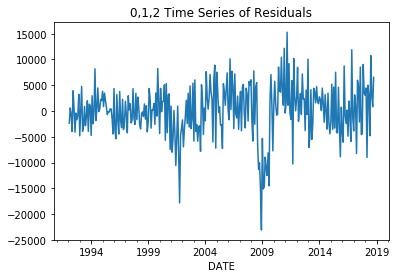

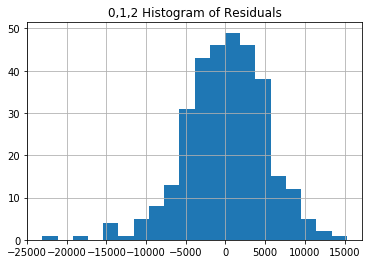

In [37]:
model_inv_012 = ARIMA(df['BUSINV'], order=(0,1,2))
model_inv_012_fit = model_inv_012.fit()
print(model_inv_012_fit.summary())
print('Inventory Residuals Description')
print(model_inv_012_fit.resid.describe())

residuals_012 = pd.DataFrame(model_inv_012_fit.resid)

residuals_012.plot(legend=False)
plt.title('0,1,2 Time Series of Residuals')

residuals_012.hist(bins=20)
plt.title('0,1,2 Histogram of Residuals')

The results match up correctly.  For further verification, let's try (1,0,0):

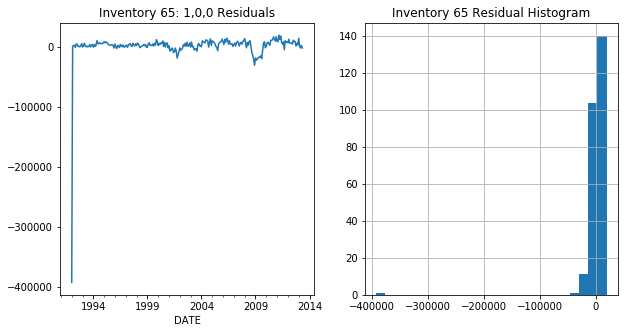

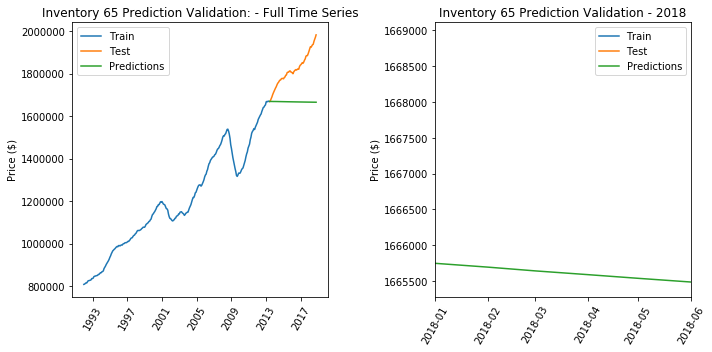

In [38]:
# 1,0,0
plot_residuals('Inventory 65', inv_train65, 1,0,0)
plot_predictions('Inventory 65', inv_train65, inv_test65, 1,0,0)

The data is not random and normalized.  As seen by the prediction line, this will not be a good model to use.

### AIC Summary

Although we determined our (p,d,q) with the mean squared error, let's do one final verfication with the Akaike Information Criteria (AIC):

(0,1,0) - AIC = 6567.586

(0,1,2) - AIC = 6406.255

Since (0,1,2) had the lowest AIC value, we will use that as our AIC min value in the context of information loss.

In [39]:
AIC010 = 6567.586
AIC012 = 6406.255

loss_010 = np.exp((AIC012 - AIC010) / 2)
print(loss_010)

9.277233125723812e-36


There is a very low probability of information loss.

### Inventory Results 
After calculating MSE and determing that we have low information loss, ARIMA **(0,1,0)** should be the best model to use for the Inventory Data.

<a id='sales'></a>
# Sales Models
[return to introduction](#introduction)

In [40]:
arima_gridsearch(sales_train65, sales_test65, range(3), range(2), range(0, 11, 2))

ARIMA config: (0, 0, 0); MSE:204632658465.72345
ARIMA config: (0, 1, 0); MSE:6269511718.7976055
ARIMA config: (0, 1, 2); MSE:7131482535.408551
ARIMA config: (0, 1, 4); MSE:5942637087.676702
ARIMA config: (0, 1, 6); MSE:6150827187.970067
ARIMA config: (0, 1, 8); MSE:6072908936.657731
ARIMA config: (0, 1, 10); MSE:5563172477.081171
ARIMA config: (1, 0, 0); MSE:5201316016.384647
ARIMA config: (1, 0, 2); MSE:5077720540.761954
ARIMA config: (1, 0, 4); MSE:6617267849.538379
ARIMA config: (1, 0, 6); MSE:7403485708.576394
ARIMA config: (1, 0, 8); MSE:7130342889.141018
ARIMA config: (1, 0, 10); MSE:8175960611.477872
ARIMA config: (1, 1, 0); MSE:7146357907.701591
ARIMA config: (1, 1, 2); MSE:6467491342.100032
ARIMA config: (1, 1, 4); MSE:5945059157.851968
ARIMA config: (1, 1, 8); MSE:5954057654.466615
ARIMA config: (2, 0, 0); MSE:5355220226.337121
ARIMA config: (2, 0, 2); MSE:7742278552.931883
ARIMA config: (2, 0, 4); MSE:7749601924.346763
ARIMA config: (2, 0, 6); MSE:7395443430.757516
ARIMA con

Let's check to see if our data is random and normally distributed for Sales 65 starting with 1,0,2.

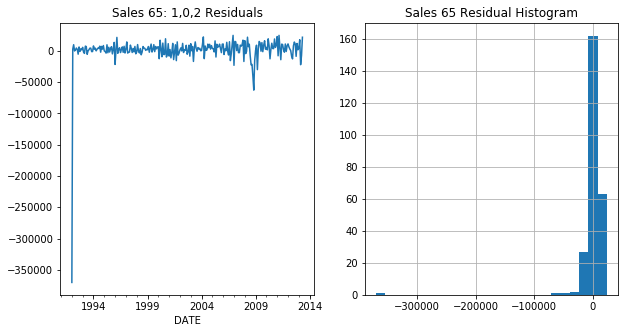

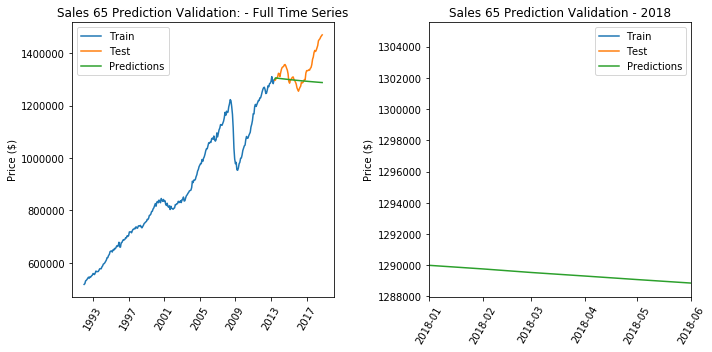

In [41]:
plot_residuals('Sales 65', sales_train65, 1, 0, 2)
plot_predictions('Sales 65', sales_train65, sales_test65, 1, 0, 2)

We will need to check the next lowest MSE score for Sales 65 because the residuals are not random and normally distributed. It should be differenced once, so we we will check the lowest MSE score with I=1.

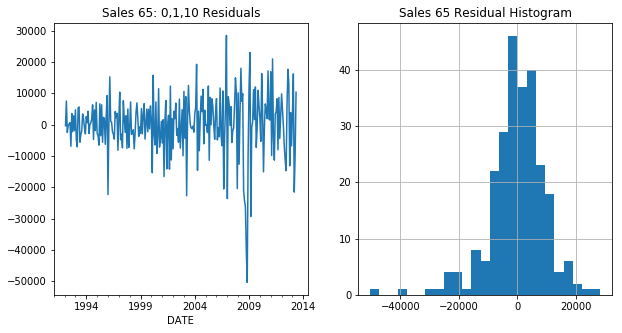

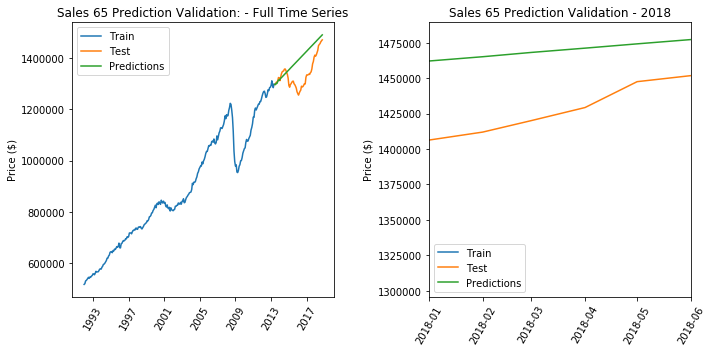

In [42]:
plot_residuals('Sales 65', sales_train65, 0, 1, 10)
plot_predictions('Sales 65', sales_train65, sales_test65, 0, 1, 10)

Looks good.  Let's verify with statsmodels:

                             ARIMA Model Results                              
Dep. Variable:           D.TOTBUSSMSA   No. Observations:                  321
Model:                ARIMA(0, 1, 10)   Log Likelihood               -3388.707
Method:                       css-mle   S.D. of innovations           9290.036
Date:                Sat, 09 Feb 2019   AIC                           6801.414
Time:                        13:05:19   BIC                           6846.671
Sample:                    02-01-1992   HQIC                          6819.484
                         - 10-01-2018                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2966.6324    996.361      2.977      0.003    1013.801    4919.464
ma.L1.D.TOTBUSSMSA      0.3011      0.057      5.303      0.000       0.190       0.412
ma.L2.D.TOTBUSSM

Text(0.5,1,'0,1,10 Histogram of Residuals')

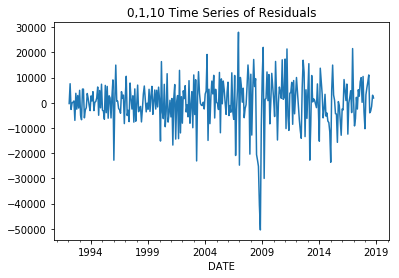

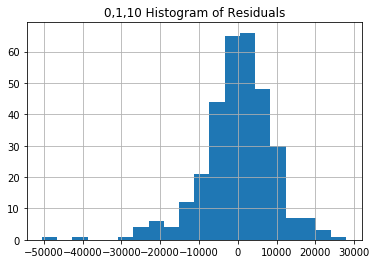

In [43]:
model_sales_0110 = ARIMA(df['TOTBUSSMSA'], order=(0,1,10))
model_sales_0110_fit = model_sales_0110.fit()
print(model_sales_0110_fit.summary())
print('Sales Residuals Description')
print(model_sales_0110_fit.resid.describe())

residuals_0110 = pd.DataFrame(model_sales_0110_fit.resid)

residuals_0110.plot(legend=False)
plt.title('0,1,10 Time Series of Residuals')

residuals_0110.hist(bins=20)
plt.title('0,1,10 Histogram of Residuals')

We got random and normalized residuals with a good prediction; however, not all of our p-values are 0.05 or lower.  Let's try 0,1,2 on the Sales data:

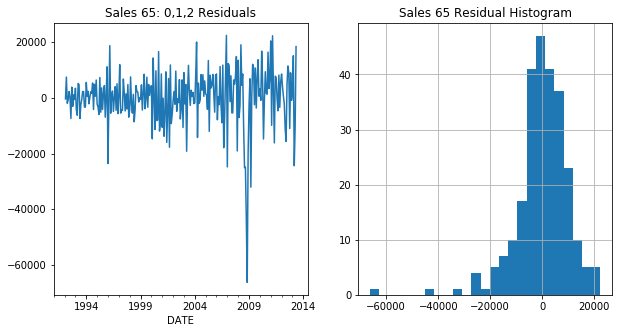

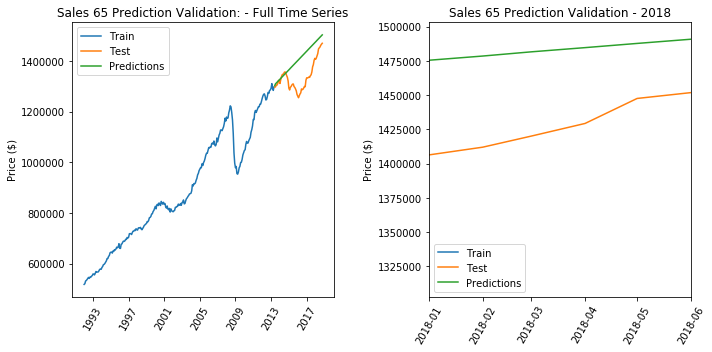

In [44]:
plot_residuals('Sales 65', sales_train65, 0, 1, 2)
plot_predictions('Sales 65', sales_train65, sales_test65, 0, 1, 2)

                             ARIMA Model Results                              
Dep. Variable:           D.TOTBUSSMSA   No. Observations:                  321
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -3405.273
Method:                       css-mle   S.D. of innovations           9790.936
Date:                Sat, 09 Feb 2019   AIC                           6818.545
Time:                        13:05:27   BIC                           6833.631
Sample:                    02-01-1992   HQIC                          6824.569
                         - 10-01-2018                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2966.6324    779.560      3.806      0.000    1438.722    4494.543
ma.L1.D.TOTBUSSMSA     0.2448      0.059      4.119      0.000       0.128       0.361
ma.L2.D.TOTBUSSMSA  

Text(0.5,1,'0,1,2 Histogram of Residuals')

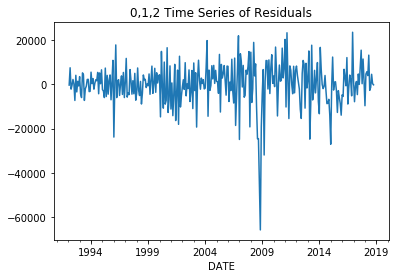

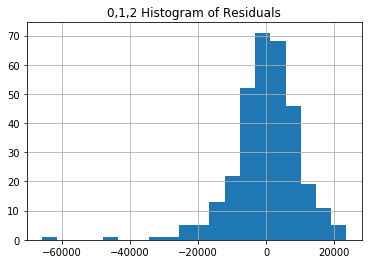

In [45]:
model_sales_012 = ARIMA(df['TOTBUSSMSA'], order=(0,1,2))
model_sales_012_fit = model_sales_012.fit()
print(model_sales_012_fit.summary())
print('Sales Residuals Description')
print(model_sales_012_fit.resid.describe())

residuals_012 = pd.DataFrame(model_sales_012_fit.resid)

residuals_012.plot(legend=False)
plt.title('0,1,2 Time Series of Residuals')

residuals_012.hist(bins=20)
plt.title('0,1,2 Histogram of Residuals')

We got random and normalized residuals with a good predictionand all of our p-values are 0.05 or lower.

### AIC Summary

Although we determined our (p,d,q) with the mean squared error, let's do one final verfication with the Akaike Information Criteria (AIC):

(0,1,10) - AIC = 6801.414

(0,1,2) - AIC = 6818.545

Since (0,1,10) had the lowest AIC value, we will use that as our AIC min value in the context of information loss.

In [46]:
AIC0110_s = 6801.414
AIC012_s = 6818.545

loss_012 = np.exp((AIC0110_s - AIC012_s) / 2)
print(loss_012)

0.00019056828046107573


There is a low probability of information loss.

### Sales Results 
After calculating MSE and determing that we have low information loss, ARIMA **(0,1,2)** should be the best model to use for the Sales Data.

<a id='further'></a>
# Further Exploration
[return to introduction](#introduction)

<a id='sarimax'></a>
# SARIMAX

Next we will use an extension of the ARIMA model - SARIMAX.  SARIMAX stands for Seasonal Autoregressive Integrated Moving Average and is an extension of ARIMA that supports univariate time series data with a seasonal component.  The "X" addition supports exogenous (external factor) variables.
Since there was a small seasonality and an association with the sales data, we will integrate that information in the new model as the "X" factor.

In addition to the trend elements of ARIMA, SARIMAX has an additional four seasonal elements:

**P:** Seasonal autoregressive order.<br>
**D:** Seasonal difference order.<br>
**Q:** Seasonal moving average order.<br>
**m:** The number of time steps for a single seasonal period.

Altogether, the parameters for SARIMAX are SARIMA(p,d,q)(P,D,Q)m.  "Exog" is our "X" factor.

In [47]:
# Fit the model - Inventory
mod_inv_010 = sm.tsa.statespace.SARIMAX(endog = df['BUSINV'], exog = df['TOTBUSSMSA'], order=(0,1,0), 
                                       seasonal_order=(0,1,0,12), trend='c', enforce_invertibility=False)
res = mod_inv_010.fit(disp=False)
print(res.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             BUSINV   No. Observations:                  322
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -3261.853
Date:                            Sat, 09 Feb 2019   AIC                           6529.705
Time:                                    13:05:29   BIC                           6540.905
Sample:                                01-01-1992   HQIC                          6534.183
                                     - 10-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    196.4374    528.768      0.372      0.710    -839.929    1232.804
TOTBUSSMSA     0.2168      0.028   

### SARIMAX Results

The intercept is the same as the constant; however, our data is differenced so the intercept is not significant. 

About 22% of the value of sales contributes to the inventory values. 

Not all of our p-values are less than 0.05, so further adjusting of the P,D,Q parameters would need to be done to get our best model configuration.  Since seasonality had a small effect compared to trends, our ARIMA models should suffice for this data.

<a id='other'></a>
# Other Verification
[return to introduction](#introduction)

Below are economic charts from https://www.macrotrends.net/ to further explore association with other economic factors.  The grey areas in the charts mark recessions.

https://www.macrotrends.net/2583/industrial-production-historical-chart

This chart tracks the Federal Reserve's Industrial Production Index, which measures real output for all facilities located in the United States manufacturing, mining, and electric, and gas utilities (excluding those in U.S. territories).

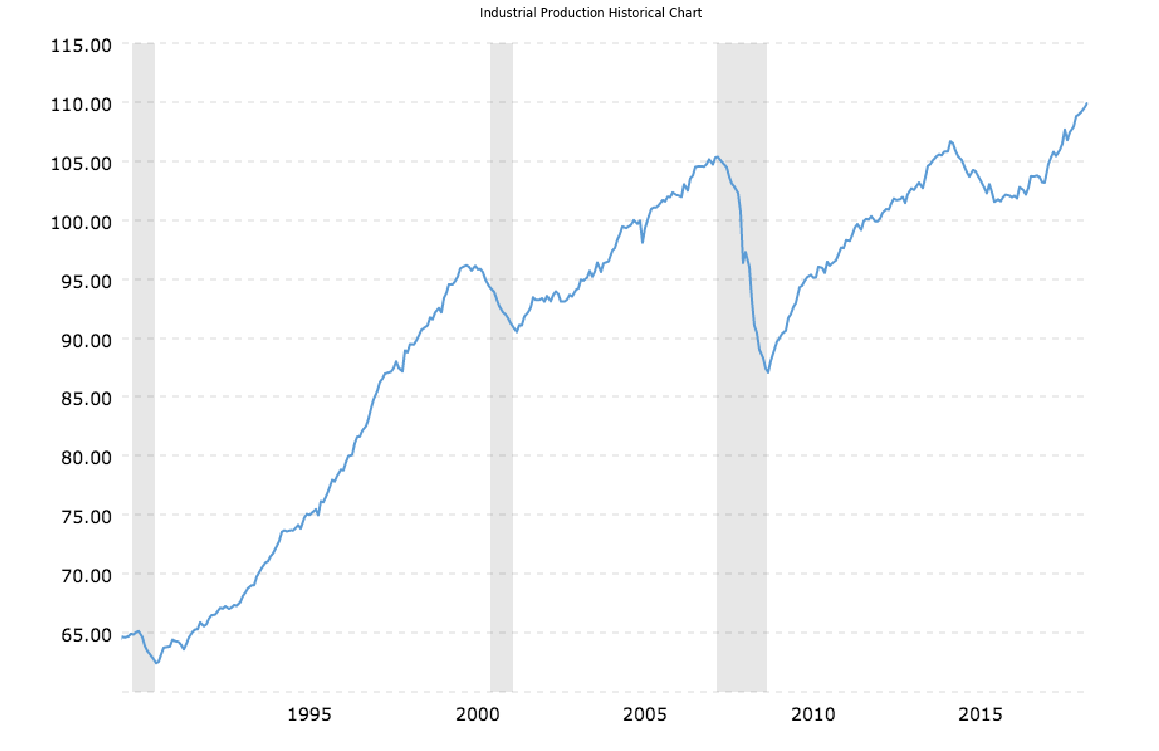

In [48]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('industrial-production-historical-chart-2019-01-30-macrotrends.png')
fig = plt.figure(figsize = (20,20))
ax3 = fig.add_subplot(111)
ax3.imshow(img, interpolation='none')
ax3.set_title('Industrial Production Historical Chart')
plt.axis('off')
plt.show()

https://www.macrotrends.net/1371/retail-sales-historical-chart

This chart displays total real (inflation-adjusted) retail and food service sales since 1992. The data is adjusted for inflation using the headline consumer price index.

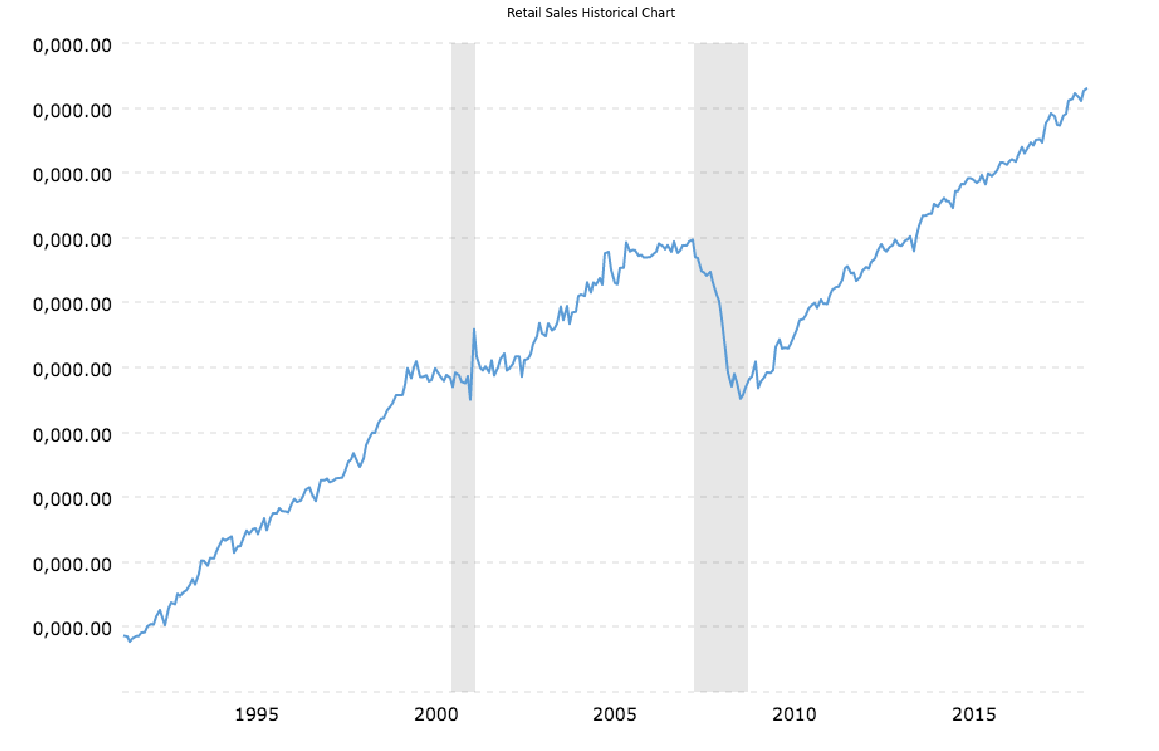

In [49]:
img_2=mpimg.imread('retail-sales-historical-chart-2019-01-30-macrotrends.png')
fig2 = plt.figure(figsize = (20,20))
ax3 = fig2.add_subplot(111)
ax3.imshow(img_2, interpolation='none')
ax3.set_title('Retail Sales Historical Chart')
plt.axis('off')
plt.show()

***Note:*** The picture file downloaded with the y axis not labelled correctly.  The far left data point is 118,643 USD and the far right data point is 203,076 USD.

### These charts look very similar to the Inventory and Sales data used throughout the notebook.  
The recessions (grey shaded areas) in these two charts above line up with the dips we had in the original data as well.  While it is good to see that our results look similar to the data from Macrotrends, this would be a good place to further research other factors that affect Inventory and Sales data - world events, unemployment rates, housing market, etc.

<a id='summary'></a>
# Summary

The analysis throughout this notebook gave us a good framework to apply to different data sets. 

[Seasonal Decomposition](#seasonaldecomposition) showed us how to find our trends, seasonality, and residuals.

**Trend** - shows both data sets are generally increasing. Similar shape to Observed.  Trend sized doubled for Inventories and triples for Sales over the time period observed.  The Trend charts are the most prominent observation.

**Seasonal** - Repeating short term cycle in a series - this is what we expect since data is continuous.  Inventories look to have their spike slightly before the seasonal sales spike (middle of year).  This makes sense as businesses typically know when to increase their inventory in anticipation of a busy sales season.  The seasonality for this data had a small effect compared to the trends.

[Linear Regression](#linear) - This verified that while our data did have a lot of correlation, the element of time was needed to properly predict future values.  Further exploration could determine other factors playing into the correlation between Inventories and Sales as well.

[ARIMA](#arima) modeling helped us determine our the optimal parameters for our best possible prediction.  We verified our constant coefficient values from the differencing charts and made sure our p-values were low enough to ensure the models were giving optimal predictions.
 
[SARIMAX](#sarimax) modeling help us factor in seasonality and exogenous factors to further improve our modeling.  Further exploration of the P,D,Q parameters could be done to optimize our model; however, since seasonality had a small effect compared to trends, our ARIMA models should suffice for this data.
 
The charts from https://www.macrotrends.net/ confirmed that our original data was an accurate representation of Inventory and Sales data in the US.  Data from FRED and Macro Trends all looked very similar when charted out.

By exploring the given data, setting up the proper parameters, determing the best model to use, and further verfying with outside factors, this set up could be useful to other companies looking to optimize their inventory.  If a company knew how much sales they were expecting based on their past sales numbers, they could adjust inventory accordingly by increasing/decreasing at the approprioate time.  Decreasing inventory is easy to do, but increasing would bring up important decisions such as renting a temporary storage unit.  Companies could prepare for a general increase in inventory rather than a seasonal increase and be better prepared, thus saving time and having a better idea of how they will need to operate in the future.

[return to introduction](#introduction)